# Plots of BGCs

This Notebook will prepare figures describing the collection of BGCs retrieved from the ELF isolate assemblies using antiSMASH v6.

## Fig. 5.1 - Plot antiSMASH BGCs by type

In [24]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from collections import defaultdict
import numpy as np
from scipy import stats

Clean the data

In [25]:
df = pd.read_csv("../ELF_master_results.csv")
df = df.sort_values(by=["BGC_count"], ascending=False)
df["actual_coverage"] = (df["# total reads"]*150)/df["Total length"] # calculate actual coverage again

df2 = pd.read_csv("ELF_all_bgcs.csv")
df2["Assembly"] = df2["file"].str.split(".").str[0]
df2["BGC_type"] = df2["BGC_type"].str.replace('[\[\]\']', '')
df2["BGC_length2"] = df2["BGC_length"].div(1000)
df["isolate_order"] =df["isolate_order"].replace('Sordariomycetes incertae sedis', 'Sordariomycetes i.s.')
df["isolate_order"] =df["isolate_order"].replace('Leotiomycetes incertae sedis', 'Leotiomycetes i.s.')
df2["order"] =df2["order"].replace('Sordariomycetes incertae sedis', 'Sordariomycetes i.s.')
df2["order"] =df2["order"].replace('Leotiomycetes incertae sedis', 'Leotiomycetes i.s.')

df2.head()

C:\Users\styleske\AppData\Local\Temp\ipykernel_11444\2279542460.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df2["BGC_type"] = df2["BGC_type"].str.replace('[\[\]\']', '')


,file,contig,partial,BGC_type,chem_class,BGC_location,BGC_length,protocluster,kind,cblast_type,...,assembly,class,order,family,genus,min_cosine,GCC,GCF,Assembly,BGC_length2
0,130.json,scaffold_1,True,NRPS,NRP,0:25880,25880,1,single,"NRPS,terpene",...,130,Eurotiomycetes,Eurotiales,Aspergillaceae,Penicillium,0.122942,GCF_4128,GCC_4,130,25.880
1,130.json,scaffold_5,True,NRPS-like,NRP,0:20667,20667,1,single,NRPS-like,...,130,Eurotiomycetes,Eurotiales,Aspergillaceae,Penicillium,0.106094,GCF_974,GCC_28,130,20.667
2,130.json,scaffold_10,True,T1PKS,Polyketide,0:19733,19733,1,single,T1PKS,...,130,Eurotiomycetes,Eurotiales,Aspergillaceae,Penicillium,0.035407,GCF_29,GCC_58,130,19.733
3,130.json,scaffold_15,True,NRPS,NRP,0:18816,18816,1,single,NaN,...,130,Eurotiomycetes,Eurotiales,Aspergillaceae,Penicillium,0.024865,GCF_25,GCC_4,130,18.816
4,130.json,scaffold_28,True,NRPS,NRP,0:16838,16838,1,single,NRPS,...,130,Eurotiomycetes,Eurotiales,Aspergillaceae,Penicillium,0.055042,GCF_999,GCC_4,130,16.838


In [26]:
# order the dataframes
order = df.groupby("isolate_order")["BGC_count"].mean().sort_values(ascending=False).index
order2 = order[0:-2] # get order without the Classes containing no BGCs

# subset data for chemical class and fungal Order
xxx = df2[["chem_class","order"]]
#xxx = xxx[xxx["order"] != "unidentified"]

# prepare contingency table of BGCs for each fungal Order then append
# empty rows for the Orders with the Orders removed above
xx = pd.crosstab(xxx['order'], xxx['chem_class']).loc[order2]
row1 = pd.DataFrame(index=['Cladosporiales'], columns=xx.columns)
row2 = pd.DataFrame(index=['Saccharomycetales'], columns=xx.columns)

# Concatenate the empty DataFrames with the original DataFrame
xx = pd.concat([xx, row1, row2], ignore_index=False)
xx = xx[["NRP", "Polyketide", "Hybrid", "Terpene", "Other", "RiPP"]]
xx

chem_class,NRP,Polyketide,Hybrid,Terpene,Other,RiPP
Coniochaetales,51,81,11,30,0,0
Eurotiales,468,397,90,59,28,1
Xylariales,485,733,59,108,43,3
Mycosphaerellales,27,12,4,0,0,0
Glomerellales,29,21,6,5,1,1
Hypocreales,701,476,88,81,10,3
Pleosporales,163,201,27,62,8,0
Sordariomycetes i.s.,16,8,3,0,1,1
Leotiomycetes i.s.,19,33,3,2,0,0
Sordariales,115,145,17,43,10,2


Categorical functions to make plotting easier

In [27]:
# function to categorize coverage data
def cov(x):
    if x < 10:
        return "0-9"
    elif x < 20:
        return "11-20"
    elif x < 30:
        return "21-30"
    elif x < 40:
        return "31-40"
    elif x < 50:
        return "41-50"
    elif x < 60:
        return "51-60"
    elif x < 70:
        return "61-70"
    elif x >= 80:
        return "71-80"
    elif x >= 90:
        return "81-90"
    elif x >= 100:
        return "91-100"
    else:
        return "100+"
df10 = df        

# function to categorize BGC length data
def cat(x):
    if x < 0.1:
        return "<0.1"
    elif x < 0.5:
        return "0.1-0.5"
    elif x < 1:
        return "0.5-1"
    elif x < 1.5:
        return "1-1.5"
    elif x < 2:
        return "1.5-2"
    elif x < 2.5:
        return "2-2.5"
    elif x < 3:
        return "2.5-3"
    elif x >= 3:
        return ">3"
    else:
        return "<0.1"

df["coverage_brac"] = df["actual_coverage"].apply(lambda x: cov(x))
df["BGC total length (Mbp)"] = df["total_BGC_length"].div(1000000).apply(lambda x: cat(x))
df["assembly length (Mbp)"] = df["Total length"].div(1000000)
df["BGC total length (Mbp)"] = df["BGC total length (Mbp)"].fillna(0)

In [28]:
df["assembly length (Mbp)"]

47     45.064903
126    31.964532
87     47.773956
40     40.552559
92     39.826919
         ...    
331          NaN
351          NaN
355          NaN
359          NaN
373          NaN
Name: assembly length (Mbp), Length: 380, dtype: float64

Next, a multiplot displaying various BGC metrics was prepared.

C:\Users\styleske\AppData\Local\Temp\ipykernel_11444\3656220803.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd["swarm"].set_xticklabels(xlabels1, rotation=45, ha='right', rotation_mode='anchor')


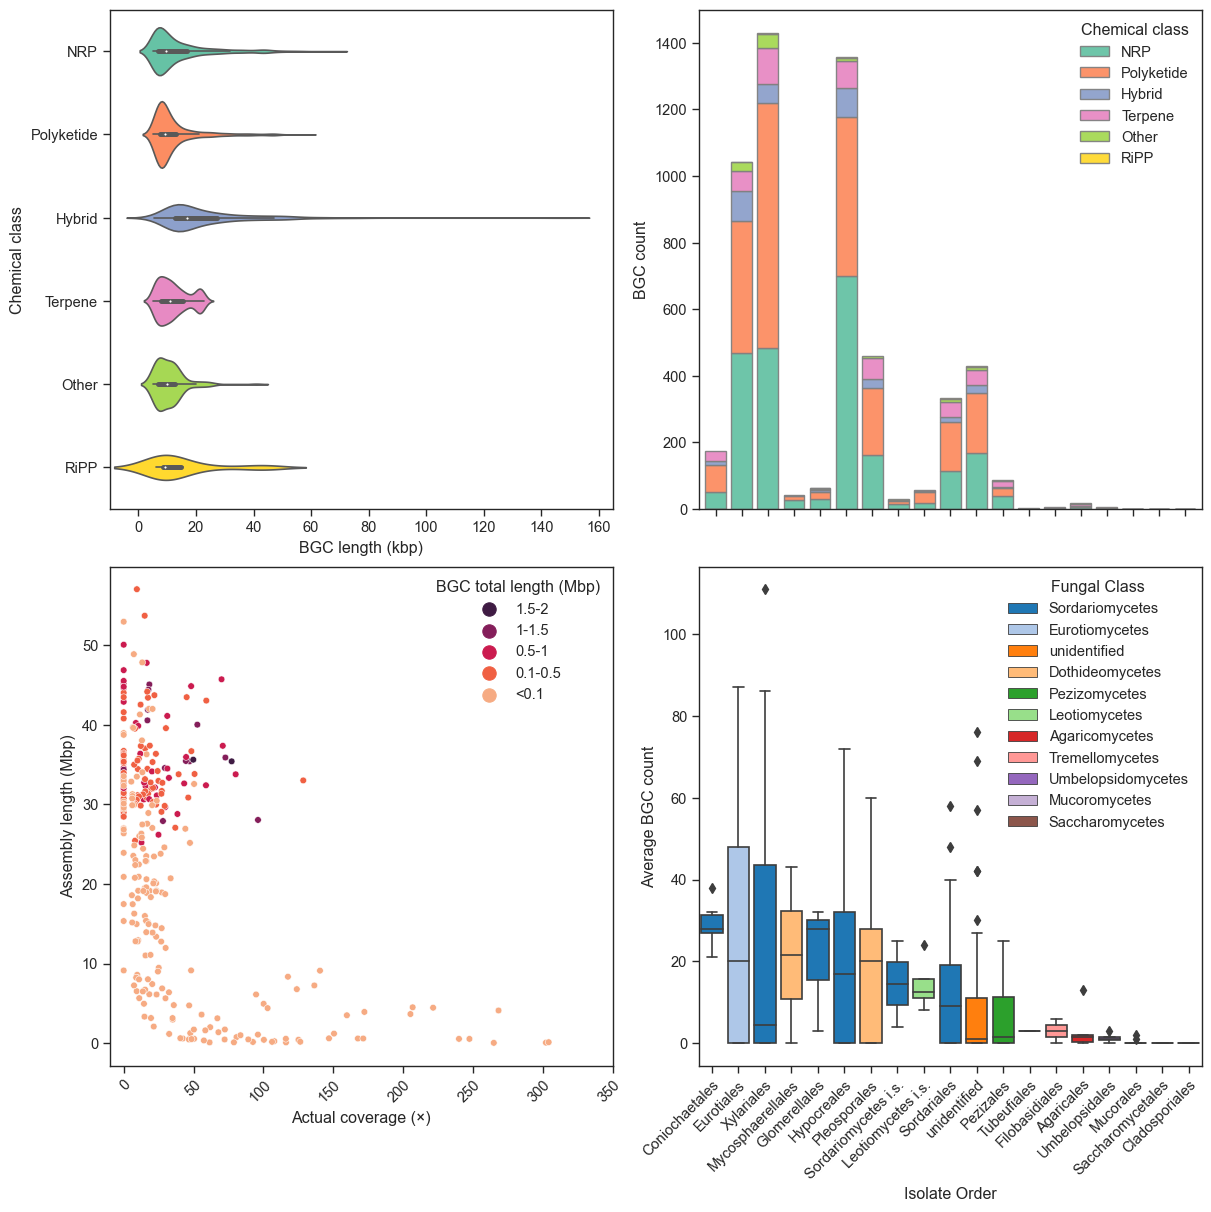

In [40]:
sns.set_palette('tab20')
sns.set_style(style='white')
sns.set_context("paper", font_scale=1.2)

fig, axd = plt.subplot_mosaic([['violin', 'bar'], ['swarm', 'box']],
    figsize=(12, 12), layout="constrained")

cmap = sns.color_palette("Set2")

# plots
sns.violinplot(data=df2, \
    x=df2["BGC_length2"], y=df2["chem_class"], ax=axd["violin"], palette=cmap, scale="area", saturation=1)
#sns.stripplot(data=df2, x=df2["BGC_length2"], y=df2["chem_class"], ax=axd["violin"], \
 #   color="black", size=1)
xx.plot(kind='bar', stacked=True, ax=axd["bar"], \
    color=cmap, width=0.8, edgecolor="grey", linewidth=1, alpha=0.95)
sns.boxplot(x=df["isolate_order"], y=df["BGC_count"], ax=axd["box"], \
    palette="tab20", dodge=False, hue=df["isolate_class"], order=order, saturation=1)
swarm_order = ["0-9","11-20","21-30","31-40","41-50","51-60","61-70","71-80","81-90","91-100","100+"]
hue_order = ['1.5-2', '1-1.5', '0.5-1', '0.1-0.5', '<0.1']
sns.scatterplot(data=df, y=df["assembly length (Mbp)"], x=df["actual_coverage"], \
    ax=axd["swarm"], hue=df['BGC total length (Mbp)'], hue_order=hue_order, palette="rocket")

# formatting for each plot
axd["violin"].set_xlim(-10,)
axd["violin"].set_ylabel("Chemical class")
axd["violin"].set_xlabel("BGC length (kbp)")

axd["bar"].set_ylim(0,1500)
axd["bar"].set_ylabel("BGC count")
axd["bar"].legend(frameon=False, title="Chemical class")
axd["bar"].set_xticklabels([])
axd["bar"].set_xlabel("")

axd["swarm"].set_xlim(-10, 350)  # Set the y-axis range from 0 to 400
axd["swarm"].set_ylabel("Assembly length (Mbp)")
axd["swarm"].set_xlabel("Actual coverage (×)")
axd["swarm"].legend(frameon=False, loc='best', title="BGC total length (Mbp)",  markerscale=2)
xlabels1 = axd["swarm"].get_xticklabels()
axd["swarm"].set_xticklabels(xlabels1, rotation=45, ha='right', rotation_mode='anchor')

axd["box"].set_ylabel("Average BGC count")
axd["box"].set_xlabel("Isolate Order")
axd["box"].legend(frameon=False, loc='best', title="Fungal Class", markerscale=1)
xlabels2 = axd["box"].get_xticklabels()
axd["box"].set_xticklabels(xlabels2, rotation=45, ha='right', rotation_mode='anchor')

for ax in axd.values():
    ax.tick_params(axis='both', which='both', left=True, bottom=True, labelbottom=True)

plt.savefig("BGC_multiplot.svg", format="svg", bbox_inches='tight')
plt.show()

## Fig. 5.2 - Plot a taxonomic breakdown of the BGCs by fungal Class. 

Added a cladogram of taxonomic relationships to the left side in an SVG editor.

*Note: I have not been able to fix the shift observed in the heatmap plot, so this, along with the plot titles and legends, were tidied up in an SVG editor.*

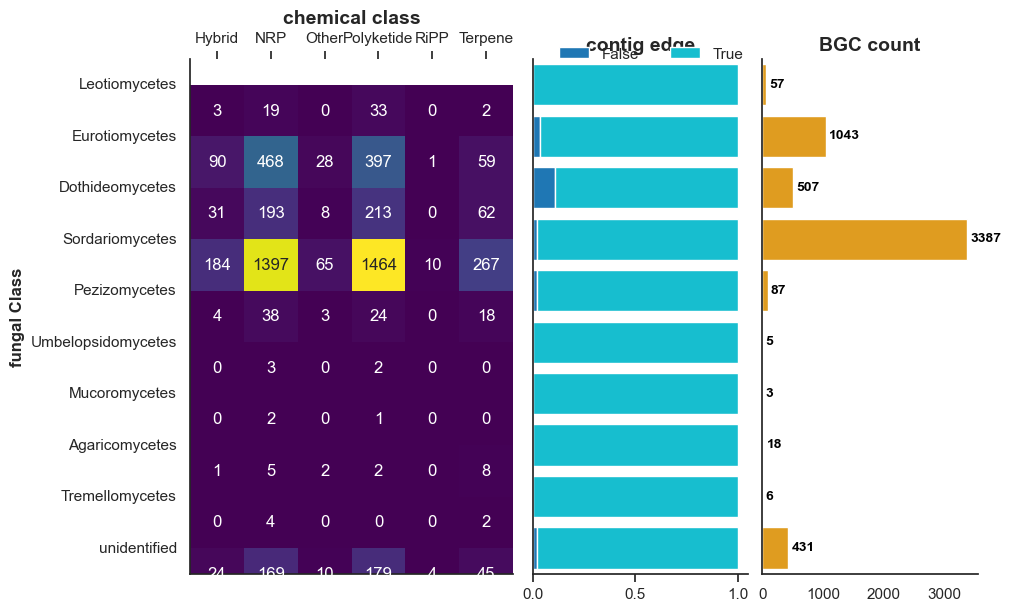

In [41]:
sns.reset_defaults()
sns.set_palette('tab10')
sns.set_style(style='white')
sns.set_context("notebook")

# prepare data into pivot table
matrix = df2.pivot_table(index='class', columns='chem_class', aggfunc='size', fill_value=0)
class_partial = df2[["class","partial"]]
cross_tab = pd.crosstab(index=class_partial['class'],
                        columns=class_partial['partial'])
cross_tab_prop = pd.crosstab(index=class_partial['class'],
                        columns=class_partial['partial'], normalize="index")
                        
# reorder index for phylogenetic tree
custom_order = {"Leotiomycetes": 1, "Eurotiomycetes": 2, "Dothideomycetes": 3,
                "Sordariomycetes": 4, "Pezizomycetes": 5, "Umbelopsidomycetes": 6, "Mucoromycetes": 7,
                "Agaricomycetes": 8, "Tremellomycetes": 9, "unidentified":10}
matrix = matrix.sort_index(key=lambda x: x.map(custom_order))
df2 = df2.sort_values(by="class", key=lambda x: x.map(custom_order))
cross_tab_prop = cross_tab_prop.sort_index(key=lambda x: x.map(custom_order))

fig, axes = plt.subplots(ncols = 3, sharey = True, gridspec_kw = {'width_ratios': [30, 20, 20]}, layout="constrained", figsize=(10, 6))
sns.heatmap(matrix, annot=True, cmap='viridis', cbar=False, ax=axes[0], fmt='d')
axes[0].xaxis.tick_top()
axes[0].set_ylim(len(matrix)-0.5, -0.5)
axes[0].set(ylabel="fungal Class", title="chemical class", xlabel=None)
cross_tab_prop.plot(kind='barh', stacked=True, colormap='tab10', ax=axes[1], width=0.8)
axes[1].tick_params(bottom=True)
axes[1].set(ylabel=None, xlabel=None, title="contig edge")
axes[1].legend(frameon=False, loc='upper center', ncols=2, title_fontproperties={'weight':"bold"}, bbox_to_anchor=(0.55, 1.05))
sns.countplot(data=df2, y="class", color="orange", ax=axes[2])
axes[2].set(ylabel=None, xlabel=None, title="BGC count")
for ax in axes.flat:
    ax.set_title(ax.get_title(), weight='bold', fontsize=14)
    ax.title.set_position([0.5, 1.1])
    ax.yaxis.label.set_weight('bold')

# add BGC counts to barplot
class_counts = df2['class'].value_counts()
class_counts = class_counts.sort_index(key=lambda x: x.map(custom_order))
for index, val in enumerate([*class_counts.index.values]):
    axes[2].text(x=class_counts[index]+50, y=index+0.05, \
                 s=f'{class_counts[index]}', color="black", fontsize=10, fontweight="bold")

sns.despine()
plt.savefig("BGC_count_by_class.svg", format="svg", bbox_inches='tight')
plt.show()

In [42]:
mibig_bgcs = df2["kc_desc"].value_counts()
display(mibig_bgcs)
mibig_bgcs.to_csv("mibig_counts.csv")

dimethylcoprogen                   88
squalestatin S1                    56
naphthopyrone                      47
1,3,6,8-tetrahydroxynaphthalene    41
clavaric acid                      39
                                   ..
penicillin                          1
andrastin A                         1
chaetoglobosins                     1
sespendole                          1
APE Ec                              1
Name: kc_desc, Length: 139, dtype: int64

## Fig. 5.3 - Plot the BLAST scores from antiSMASH modules against BGC length

The scatterplot below shows the scores of the ClusterBlast and KnownClusterBLast modules against the respective BGC-lengths. This highlights that whilst a proportion of BGCs are highly similar to existing BGCs in each of the module databases, most are unrelated and many of these unrelated BGCs are quite large.

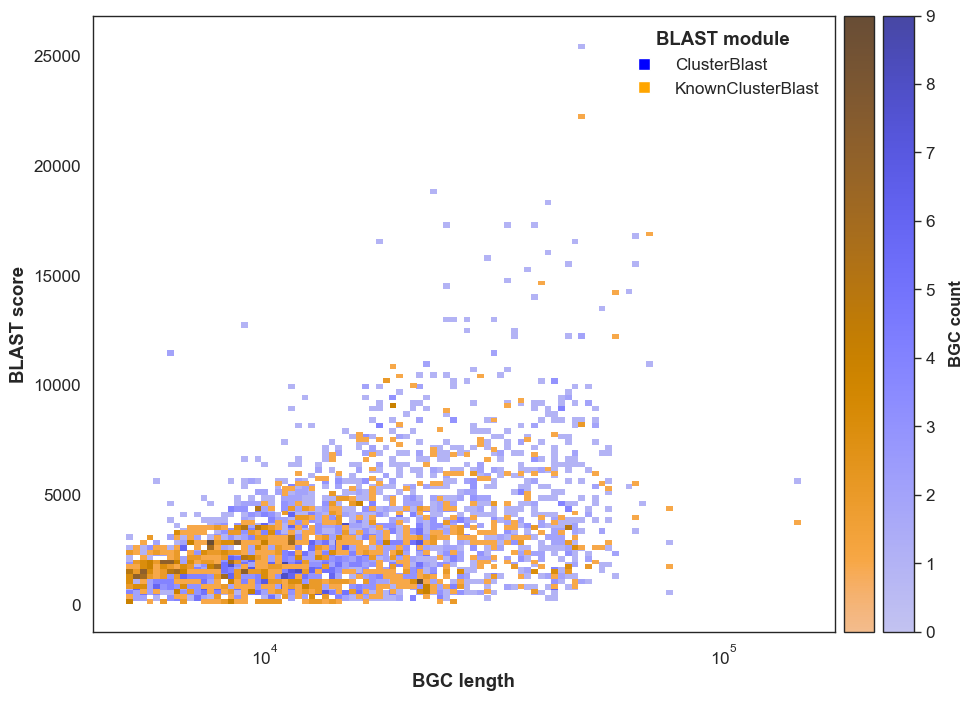

In [43]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set_palette('tab10')
sns.set_style(style='white')
sns.set_context("paper", font_scale=1.4)

ax = sns.histplot(x=df2["BGC_length"], y=df2["cblast_score"], color='blue', bins=100, label="ClusterBlast", log_scale=(True, False), cbar=True, cbar_kws={"pad": -0.1})
ax = sns.histplot(x=df2["BGC_length"], y=df2["kc_blast_score"], color='orange', bins=100, label='KnownClusterBlast', log_scale=(True, False), cbar=True, cbar_kws={"pad": 0.01})

handles = [Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=8),
           Line2D([0], [0], marker='s', color='w', markerfacecolor='orange', markersize=8)]
ax.legend(handles, ["ClusterBlast", "KnownClusterBlast"], frameon=False, loc='upper right', title="BLAST module", title_fontproperties={'weight':"bold"})
ax.set_ylabel("BLAST score", fontproperties={'weight':"bold"})
ax.set_xlabel("BGC length", fontproperties={'weight':"bold"})

# Set the label properties of the colorbar
colorbar2 = ax.collections[0].colorbar
colorbar2.set_label("BGC count", fontsize=12, labelpad=10, weight="bold")
colorbar1 = ax.collections[1].colorbar
colorbar1.set_ticks([])
for ax in axd.values():
    ax.tick_params(axis='both', which='both', left=True, bottom=True, labelbottom=True)

plt.savefig("module_blast.svg", format="svg", bbox_inches='tight')
plt.show()

Same plot as above but BLAST score is adjusted for BGC length. This plot is not in my thesis.

C:\Users\styleske\AppData\Local\Temp\ipykernel_11444\1852114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df200["new_cblast"] = df200["cblast_score"]/df200["BGC_length"]
C:\Users\styleske\AppData\Local\Temp\ipykernel_11444\1852114.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df200["new_kcblast"] = df200["kc_blast_score"]/df200["BGC_length"]


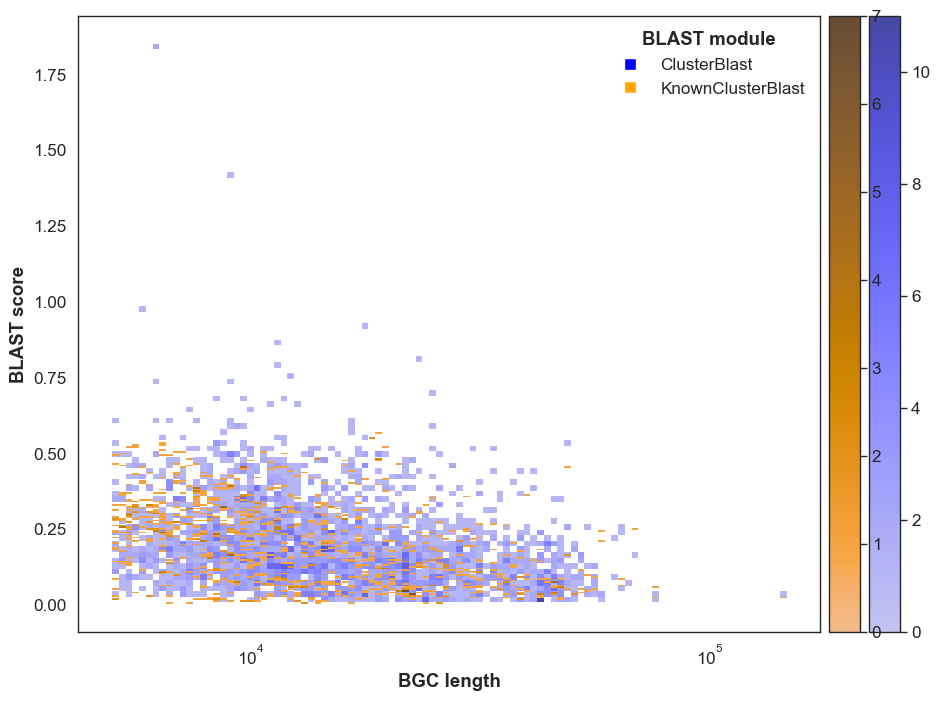

In [44]:
df200 = df2[["BGC_length", "cblast_score", "kc_blast_score"]]

df200["new_cblast"] = df200["cblast_score"]/df200["BGC_length"]
df200["new_kcblast"] = df200["kc_blast_score"]/df200["BGC_length"]

df200
ax = sns.histplot(x=df200["BGC_length"], y=df200["new_cblast"], color='blue', bins=100, label="ClusterBlast", log_scale=(True, False), cbar=True, cbar_kws={"pad": -0.1})
ax = sns.histplot(x=df200["BGC_length"], y=df200["new_kcblast"], color='orange', bins=100, label='KnownClusterBlast', log_scale=(True, False), cbar=True, cbar_kws={"pad": 0.01})

handles = [Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=8),
           Line2D([0], [0], marker='s', color='w', markerfacecolor='orange', markersize=8)]
ax.legend(handles, ["ClusterBlast", "KnownClusterBlast"], frameon=False, loc='upper right', title="BLAST module", title_fontproperties={'weight':"bold"})
ax.set_ylabel("BLAST score", fontproperties={'weight':"bold"})
ax.set_xlabel("BGC length", fontproperties={'weight':"bold"})
plt.show()
